# 2022年 世界モデル 第7回演習

本演習では, いわゆる世界モデルを用いた強化学習アルゴリズムである **RSSM (Recurrent State Space Model)**[[1]](#scrollTo=J_PCEOJ69prx) と**Dreamer**[[2]](#scrollTo=J_PCEOJ69prx)を実装します.

## 目次

1. [準備](#scrollTo=yDN8Ohc0Mh8C)
2. [環境の設定](#scrollTo=_eayBK1HPV5H)
3. [RSSM](#scrollTo=B3rWEGtkA3e_&line=1&uniqifier=1)
4. [RSSMの実装](#scrollTo=xJfU7ygCMeJn)
5. [補助機能の実装](#scrollTo=WhlVvU3aZ5FC)
6. [Dreamerの実装](#scrollTo=keAW0J-qS24Q)
7. [エージェントの実装](#scrollTo=GdKZ1S2_boOd)
8. [ハイパーパラメータの設定と学習の準備](#scrollTo=QUPWAkpyc9Z-)
9. [学習](#scrollTo=yUoI0l9Ee0Tp)
10. [結果の確認](#scrollTo=E3F2tAU0kepm)
11. [参考文献](##scrollTo=J_PCEOJ69prx&line=4&uniqifier=1)

##1.準備
まず, 演習を行うために必要な準備を行います.

In [ ]:
import time
import os
import gc

import gym
import pandas as pd

import pathlib
import numpy as np
import matplotlib.pyplot as plt
import imageio
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
from tqdm import tqdm

import torch
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence
from torch import nn
from torch.nn import functional as F
from torch.nn.utils import clip_grad_norm_
from torch.utils.tensorboard import SummaryWriter

# 可視化のためにTensorBoardを用いるので, Colab上でTensorBoardを表示するための宣言を行う
%load_ext tensorboard

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2.動画の変換

In [ ]:
# base_dir = "/content/gdrive/My Drive/博士課程/world_model_2022/最終課題"
base_dir = "/content/drive/MyDrive/Colab Notebooks/WorldModel/最終課題"
original_img_dir = f"{base_dir}/original_imgs"
src_img_dir = f"{base_dir}/src_imgs"
fps = 30

os.makedirs(original_img_dir, exist_ok=True)
os.makedirs(src_img_dir, exist_ok=True)

In [ ]:
# !ffmpeg -i "$base_dir/shinkansen_480p.mov" -vf fps="$fps" "$original_img_dir/%04d.jpg"
!ffmpeg -i "$base_dir/IMG_4396.MOV" -vf fps="$fps" "$original_img_dir/%04d.jpg"

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [ ]:
original_img_filenames = list(pathlib.Path(original_img_dir).glob('**/*.jpg'))
img_filenames = [str(filename).replace("original", "src") for filename in original_img_filenames]

In [ ]:
img = Image.open(original_img_filenames[0])
img.size

(720, 1280)

In [ ]:
crop = img.crop((0, 200, 800, 1000))
crop.size

(800, 800)

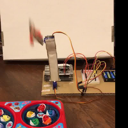

In [ ]:
resize = crop.resize((128,128))
resize

In [ ]:
# 保存した画像を128x128にクロップ(不使用)
def make_crop_img(img, crop_size=64):
    w, h = img.size[0], img.size[1]
    center = (w // 2, h // 2)
    # (left, uppper, right, bottom)
    crop = img.crop((center[0] - crop_size // 2, center[1] - crop_size // 2, center[0] + crop_size // 2, center[1] + crop_size // 2))
    return crop

In [ ]:
# 保存した画像を定数でクロップして、リサイズする
def make_crop_and_resize_img(img, crop_left, crop_upper, crop_rigt, crop_bottom, size):
    assert (crop_rigt - crop_left) == (crop_bottom - crop_upper)
    # (left, uppper, right, bottom)
    crop = img.crop((crop_left, crop_upper, crop_rigt, crop_bottom))
    resize = crop.resize((size, size))
    return resize

In [ ]:
# クロップ＆サイズ変更
for original_img_filename, img_filename in zip(tqdm(original_img_filenames), img_filenames):
    img = Image.open(original_img_filename)
    # アームと魚を全部入れるために画像の右側をはみ出してクロップする
    crop_img = make_crop_and_resize_img(img, crop_left=0, crop_upper=200, crop_rigt=800, crop_bottom=1000, size=128)
    crop_img.save(img_filename, quality=100)

100%|██████████| 2148/2148 [04:36<00:00,  7.78it/s]


確認のために作成した画像をつなげて動画として再生

In [ ]:
def make_animation_from_images(img_dir):
    img_filenames = list(pathlib.Path(img_dir).glob('**/*.jpg'))
    fig = plt.figure(figsize=(3,3))

    imgs = []
    for img_filename in img_filenames:
        img = plt.imshow(np.asarray(Image.open(img_filename)), animated=True)
        plt.axis('off')
        imgs.append([img])

    anime = animation.ArtistAnimation(fig, imgs, interval=50, repeat_delay=1000)
    plt.close()
    return anime

In [ ]:
HTML(make_animation_from_images(img_dir=src_img_dir).to_html5_video())

In [ ]:
data = {
    "filename": img_filenames,
    "reward": np.random.rand(len(img_filenames))  # rewardは適当
}
# 1軸想定。2軸以上にするなら色々変更必要。主に次元の扱い。カラムを増やしてもいいし、同一カラム内にタプルで保存してもいい
action_dim = 1
data.update({f"action": np.random.rand(len(img_filenames)) for i in range(1)})
df = pd.DataFrame(data)
df["is_done"] = False
# 適当に100画像ごとにEP完了フラグをつける
df["is_done"].iloc[100::100] = True
df.head(101)

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,filename,reward,action,is_done
0,/content/drive/MyDrive/Colab Notebooks/WorldMo...,0.116218,0.082973,False
1,/content/drive/MyDrive/Colab Notebooks/WorldMo...,0.838852,0.257231,False
2,/content/drive/MyDrive/Colab Notebooks/WorldMo...,0.144653,0.856882,False
3,/content/drive/MyDrive/Colab Notebooks/WorldMo...,0.336852,0.394698,False
4,/content/drive/MyDrive/Colab Notebooks/WorldMo...,0.749769,0.281678,False
...,...,...,...,...
96,/content/drive/MyDrive/Colab Notebooks/WorldMo...,0.919897,0.092505,False
97,/content/drive/MyDrive/Colab Notebooks/WorldMo...,0.476225,0.387216,False
98,/content/drive/MyDrive/Colab Notebooks/WorldMo...,0.274466,0.164961,False
99,/content/drive/MyDrive/Colab Notebooks/WorldMo...,0.497326,0.267345,False


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## 3.RSSM
RSSMは以下のパーツに分けることができます.

**Deterministic state model:**
> $h_{t}=f(h_{t-1}, s_{t-1}, a_{t-1})$

**Stochastic state model:**
> $s_{t}$ ~ $p(s_{t} | h_{t})$

**Observation model:**
> $o_{t}$ ~ $p(o_{t} | h_{t}, s_{t})$

**Reward model:**
> $r_{t}$~ $p(r_{t} | h_{t}, s_{t})$

[以下の画像](https://towardsai.net/p/machine-learning/dreamer-8b5a42acebbf)は1つの時間ステップでのRSSMの挙動を示しています.

![1stepあたりの模式図](https://cdn-images-1.medium.com/max/1024/1*4b2l7Fr4eavQV5ZMouCT-g.png)



Deterministic state modelで, RNNは, 前の時間ステップの行動$a_{t-1}$と事後確率状態$s'_{t-1}$, 決定論的状態$h_{t-1}$を入力とし, 決定論的状態$h_t$を出力します.

$h_{t}$は (1)事前状態確率$s_{t}$を計算するために, 1つの隠れ層を持つMLPに供給され (本実装では線形変換）, (2)事後確率状態$s'_{t}$を計算するために, 画像埋め込み$e_t$(本実装では`embedded_obs`と表現される）と連結され, 別の単層MLP(線形変換)に供給されます.

その後, $h_{t}$と$s'_{t}$を連結したものを用いて, 画像や報酬などを再構成します.














## 4.RSSMの実装


上記をもとにRSSMの実装を行います. 実装では, 以下の3つのクラスに分けて実装します.

* 状態遷移を担うクラス（TransitionModel）
* 観測を復元するデコーダクラス（ObservationModel）
* 報酬を予測するクラス（RewardModel）

※TransitionModelは上記Deterministic state model, Stochastic state modelを合体させています.


まず実装するのがTransitionModelです.

1ステップ先の未来の状態表現を予測する機能を担います.

学習の方針として, 状態遷移を用いた1ステップ先の未来の状態表現の分布である"prior"と, 1ステップ先の観測の情報を取り込んで計算した状態表現の分布である"posterior"が一致するように学習します.

"posterior"は後に観測の再構成誤差と報酬の予測誤差によって学習されるので, "posterior"は上記の2つの誤差によって妥当な状態表現になるように学習され, 同時に"prior"をそれに近づけることで, 状態表現の空間で未来の予測が可能になるように学習する, というイメージです. よって, これを踏まえたクラスの実装になっています.

状態表現として, 決定的な状態である"rnn_hidden"と, 確率的な状態である"state"の両方を持っています.

In [ ]:
class TransitionModel(nn.Module):
    """
    このクラスは複数の要素を含んでいます.
    決定的状態遷移 （RNN) : h_t+1 = f(h_t, s_t, a_t)
    確率的状態遷移による1ステップ予測として定義される "prior" : p(s_t+1 | h_t+1)
    観測の情報を取り込んで定義される "posterior": q(s_t+1 | h_t+1, e_t+1)
    """
    def __init__(self, state_dim, action_dim, rnn_hidden_dim,
                 hidden_dim=200, min_stddev=0.1, act=F.elu):
        super(TransitionModel, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.rnn_hidden_dim = rnn_hidden_dim
        self.fc_state_action = nn.Linear(state_dim + action_dim, hidden_dim)

        self.fc_rnn_hidden = nn.Linear(rnn_hidden_dim, hidden_dim)
        self.fc_state_mean_prior = nn.Linear(hidden_dim, state_dim)
        self.fc_state_stddev_prior = nn.Linear(hidden_dim, state_dim)
        self.fc_rnn_hidden_embedded_obs = nn.Linear(rnn_hidden_dim + 1024, hidden_dim)
        self.fc_state_mean_posterior = nn.Linear(hidden_dim, state_dim)
        self.fc_state_stddev_posterior = nn.Linear(hidden_dim, state_dim)

        #next hidden stateを計算
        self.rnn = nn.GRUCell(hidden_dim, rnn_hidden_dim)
        self._min_stddev = min_stddev
        self.act = act


    def forward(self, state, action, rnn_hidden, embedded_next_obs):
        """
        h_t+1 = f(h_t, s_t, a_t)
        prior p(s_t+1 | h_t+1) と posterior q(s_t+1 | h_t+1, e_t+1) を返す
        この2つが近づくように学習する
        """
        next_state_prior, rnn_hidden = self.prior(self.reccurent(state, action, rnn_hidden))
        next_state_posterior = self.posterior(rnn_hidden, embedded_next_obs)
        return next_state_prior, next_state_posterior, rnn_hidden

    def reccurent(self, state, action, rnn_hidden):
        """
        h_t+1 = f(h_t, s_t, a_t)を計算する
        """
        hidden = self.act(self.fc_state_action(torch.cat([state, action], dim=1)))
        #h_t+1を求める
        rnn_hidden = self.rnn(hidden, rnn_hidden)
        return rnn_hidden

    def prior(self, rnn_hidden):
        """
        prior p(s_t+1 | h_t+1) を計算する
        """
        #h_t+1を求める（ヒント: self.act, self.fc_rnn_hiddenを使用）
        hidden = self.act(self.fc_rnn_hidden(rnn_hidden))

        mean = self.fc_state_mean_prior(hidden)
        stddev = F.softplus(self.fc_state_stddev_prior(hidden)) + self._min_stddev
        return Normal(mean, stddev), rnn_hidden

    def posterior(self, rnn_hidden, embedded_obs):
        """
        posterior q(s_t+1 | h_t+1, e_t+1)  を計算する
        """
        # h_t+1, o_t+1を結合し, q(s_t+1 | h_t+1, e_t+1) を計算する
        hidden = self.act(self.fc_rnn_hidden_embedded_obs(torch.cat([rnn_hidden, embedded_obs], dim=1)))
        mean = self.fc_state_mean_posterior(hidden)
        stddev = F.softplus(self.fc_state_stddev_posterior(hidden)) + self._min_stddev
        return Normal(mean, stddev)

次に, 観測を再構成するデコーダを実装します.

In [ ]:
class ObservationModel(nn.Module):
    """
    p(o_t | s_t, h_t)
    低次元の状態表現から画像を再構成するデコーダ (3, 64, 64)
    """
    def __init__(self, state_dim, rnn_hidden_dim):
        super(ObservationModel, self).__init__()
        self.fc = nn.Linear(state_dim + rnn_hidden_dim, 1024)
        self.dc1 = nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=4)
        self.dc2 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=4)
        self.dc3 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=4)
        self.dc4 = nn.ConvTranspose2d(128, 3, kernel_size=2, stride=2)


    def forward(self, state, rnn_hidden):
        hidden = self.fc(torch.cat([state, rnn_hidden], dim=1))
        hidden = hidden.view(hidden.size(0), 1024, 1, 1)
        hidden = F.relu(self.dc1(hidden))
        hidden = F.relu(self.dc2(hidden))
        hidden = F.relu(self.dc3(hidden))
        obs = self.dc4(hidden)
        return obs

次に, 報酬を予測するRewardモデルを実装します.

In [ ]:
class RewardModel(nn.Module):
    """
    p(r_t | s_t, h_t)
    低次元の状態表現から報酬を予測する
    """
    def __init__(self, state_dim, rnn_hidden_dim, hidden_dim=400, act=F.elu):
        super(RewardModel, self).__init__()
        self.fc1 = nn.Linear(state_dim + rnn_hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)
        self.act = act


    def forward(self, state, rnn_hidden):
        hidden = self.act(self.fc1(torch.cat([state, rnn_hidden], dim=1)))
        hidden = self.act(self.fc2(hidden))
        hidden = self.act(self.fc3(hidden))
        reward = self.fc4(hidden)
        return reward

最後に, 上記で定義された３つのモデルを`RSSM`クラスとしてまとめます.




In [ ]:
class RSSM:
    def __init__(self, state_dim, action_dim, rnn_hidden_dim, ):
        self.transition = TransitionModel(state_dim, action_dim, rnn_hidden_dim).to(device)
        self.observation = ObservationModel(state_dim, rnn_hidden_dim,).to(device)
        self.reward = RewardModel(state_dim, rnn_hidden_dim,).to(device)

## 5.補助機能の実装

モデルの実装の前に, いくつか学習上必要になる補助機能を実装しておきましょう. 具体的にはリプレイバッファ, 観測の前処理を行う関数, λ-returnを計算する関数 の3つです.

まずはリプレイバッファを実装します. ただし, RNNを使う関係上一連の系列として経験をサンプルしてくる必要があるため, DQNの時よりは少し実装に工夫が必要です.

In [ ]:
#　今回のReplayBuffer
class ReplayBuffer(object):
    """
    RNNを用いて訓練するのに適したリプレイバッファ
    """
    def __init__(self, capacity, observation_shape, action_dim):
        self.capacity = capacity

        self.observations = np.zeros((capacity, *observation_shape), dtype=np.uint8)
        self.actions = np.zeros((capacity, action_dim), dtype=np.float32)
        self.rewards = np.zeros((capacity, 1), dtype=np.float32)
        self.done = np.zeros((capacity, 1), dtype=np.bool)

        self.index = 0
        self.is_filled = False

    def push(self, observation, action, reward, done):
        """
        リプレイバッファに経験を追加する
        """
        self.observations[self.index] = observation
        self.actions[self.index] = action
        self.rewards[self.index] = reward
        self.done[self.index] = done

        # indexは巡回し, 最も古い経験を上書きする
        if self.index == self.capacity - 1:
            self.is_filled = True
        self.index = (self.index + 1) % self.capacity

    def sample(self, batch_size, chunk_length):
        """
        経験をリプレイバッファからサンプルします. （ほぼ）一様なサンプルです
        結果として返ってくるのは観測(画像), 行動, 報酬, 終了シグナルについての(batch_size, chunk_length, 各要素の次元)の配列です
        各バッチは連続した経験になっています
        注意: chunk_lengthをあまり大きな値にすると問題が発生する場合があります
        """
        episode_borders = np.where(self.done)[0]
        sampled_indexes = []
        for _ in range(batch_size):
            cross_border = True
            while cross_border:
                initial_index = np.random.randint(len(self) - chunk_length + 1)
                final_index = initial_index + chunk_length - 1
                cross_border = np.logical_and(initial_index <= episode_borders,
                                              episode_borders < final_index).any()#論理積
            sampled_indexes += list(range(initial_index, final_index + 1))

        sampled_observations = self.observations[sampled_indexes].reshape(
            batch_size, chunk_length, *self.observations.shape[1:])
        sampled_actions = self.actions[sampled_indexes].reshape(
            batch_size, chunk_length, self.actions.shape[1])
        sampled_rewards = self.rewards[sampled_indexes].reshape(
            batch_size, chunk_length, 1)
        sampled_done = self.done[sampled_indexes].reshape(
            batch_size, chunk_length, 1)
        return sampled_observations, sampled_actions, sampled_rewards, sampled_done

    def __len__(self):
        return self.capacity if self.is_filled else self.index

次に観測の前処理を行う関数を実装します. これは簡単です. ちなみに, これもラッパーとして最初から適用してしまわないのは, リプレイバッファにはより容量の小さなnp.uint8の形式で保存しておきたいためです.

In [ ]:
def preprocess_obs(obs):
    """
    画像の変換. [0, 255] -> [-0.5, 0.5]
    """
    obs = obs.astype(np.float32)
    normalized_obs = obs / 255.0 - 0.5
    return normalized_obs

Dreamerでは価値関数の学習を行いますが, このために通常のTD誤差ではなく, **TD(λ)をベースにしたλ-return**としてターゲット価値を計算し, それと現在の予測価値の誤差を用います. そのためにλ-returnを計算する関数をここで実装しておきます.

In [ ]:
def lambda_target(rewards, values, gamma, lambda_):
    """
    価値関数の学習のためのλ-returnを計算します
    """
    V_lambda = torch.zeros_like(rewards, device=rewards.device)

    H = rewards.shape[0] - 1
    V_n = torch.zeros_like(rewards, device=rewards.device)
    V_n[H] = values[H]
    for n in range(1, H+1):
        # まずn-step returnを計算します
        # 注意: 系列が途中で終わってしまったら, 可能な中で最大のnを用いたn-stepを使います
        V_n[:-n] = (gamma ** n) * values[n:]
        for k in range(1, n+1):
            if k == n:
                V_n[:-n] += (gamma ** (n-1)) * rewards[k:]
            else:
                V_n[:-n] += (gamma ** (k-1)) * rewards[k:-n+k]

        # lambda_でn-step returnを重みづけてλ-returnを計算します
        if n == H:
            V_lambda += (lambda_ ** (H-1)) * V_n
        else:
            V_lambda += (1 - lambda_) * (lambda_ ** (n-1)) * V_n

    return V_lambda

## 6.Dreamerの実装

続いてDreamerの実装です.Dreamerの実装では以下の3クラスは上で定義したRSSMの各クラスと同義ですので,
改めて定義はしておらず`RSSM`クラスを呼び出して使用することとします.
* 状態遷移を担うクラス(TransitionModel)
* 観測を復元するデコーダクラス(ObservationModel)
* 報酬を予測するクラス(RewardModel)


そのため,新たに定義するモデルは, 以下の３つのみになります.
* 観測の画像をベクトルに変換するエンコーダクラス(Encoder)
* 価値関数を計算するクラス(ValueModel)
* 実際に行動を決定するクラス(ActionModel)


まずエンコーダを実装します. ここでは, CNN(Convolutional Neural Network)を用いて, 観測の画像をベクトルに変換します.

In [ ]:
class Encoder(nn.Module):
    """
    (3, 128, 128)の画像を(1024,)のベクトルに変換するエンコーダ
    """
    def __init__(self):
        super(Encoder, self).__init__()
        self.cv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2)
        self.cv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.cv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2)
        self.cv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2)
        self.cv5 = nn.Conv2d(256, 256, kernel_size=4, stride=2)

    def forward(self, obs):
        hidden = F.relu(self.cv1(obs))
        hidden = F.relu(self.cv2(hidden))
        hidden = F.relu(self.cv3(hidden))
        hidden = F.relu(self.cv4(hidden))
        embedded_obs = F.relu(self.cv5(hidden)).reshape(hidden.size(0), -1)
        return embedded_obs

ここからがDreamerの中核となる部分で, RSSMの学習を通して獲得された低次元の状態表現の上でActor-Criticを行います.


以下で, 価値関数を近似するValueモデル $v_{\phi}(s_{\tau})　\approx E_{q(.|s_{\tau})}(\sum_{\tau=t}^{t+H}(\gamma^{\tau-t}r_{\tau}) )$ を実装します. Q学習などで用いられる状態行動価値関数Q(s, a)ではなく, 状態価値関数V(s)であることに多少の注意が必要です.

In [ ]:
class ValueModel(nn.Module):
    """
    低次元の状態表現(state_dim + rnn_hidden_dim)から状態価値を出力する
    """
    def __init__(self, state_dim, rnn_hidden_dim, hidden_dim=400, act=F.elu):
        super(ValueModel, self).__init__()
        self.fc1 = nn.Linear(state_dim + rnn_hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)
        self.act = act

    def forward(self, state, rnn_hidden):
        hidden = self.act(self.fc1(torch.cat([state, rnn_hidden], dim=1)))
        hidden = self.act(self.fc2(hidden))
        hidden = self.act(self.fc3(hidden))
        state_value = self.fc4(hidden)
        return state_value

最後です. 実際に行動を出力するActionモデル $a_{\tau} \sim q_{\delta}(a_{\tau}|s_{\tau})$ を実装します.

Actionモデルは価値の見積もりを最大化することを目的とします.



In [ ]:
class ActionModel(nn.Module):
    """
    低次元の状態表現(state_dim + rnn_hidden_dim)から行動を計算するクラス
    """
    def __init__(self, state_dim, rnn_hidden_dim, action_dim,
                 hidden_dim=400, act=F.elu, min_stddev=1e-4, init_stddev=5.0):
        super(ActionModel, self).__init__()
        self.fc1 = nn.Linear(state_dim + rnn_hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, action_dim)
        self.fc_stddev = nn.Linear(hidden_dim, action_dim)
        self.act = act
        self.min_stddev = min_stddev
        self.init_stddev = np.log(np.exp(init_stddev) - 1)

    def forward(self, state, rnn_hidden, training=True):
        """
        training=Trueなら, NNのパラメータに関して微分可能な形の行動のサンプル（Reparametrizationによる）を返します
        training=Falseなら, 行動の確率分布の平均値を返します
        """
        hidden = self.act(self.fc1(torch.cat([state, rnn_hidden], dim=1)))
        hidden = self.act(self.fc2(hidden))
        hidden = self.act(self.fc3(hidden))
        hidden = self.act(self.fc4(hidden))

        # Dreamerの実装に合わせて少し平均と分散に対する簡単な変換が入っています
        mean = self.fc_mean(hidden)
        mean = 5.0 * torch.tanh(mean / 5.0)
        stddev = self.fc_stddev(hidden)
        stddev = F.softplus(stddev + self.init_stddev) + self.min_stddev

        if training:
            action = torch.tanh(Normal(mean, stddev).rsample())#微分可能にするためrsample()
        else:
            action = torch.tanh(mean)
        return action

実装の詳細まで掴みきれなくとも, 個々のクラスが担っている役割が大雑把にでもわかっていただければ幸いです.

## 7.エージェントの実装

Dreamerでは行動を計算するために低次元の状態表現が必要で, この状態表現はRSSMを用いて計算されるため, テスト時もこの状態表現のためにRSSMによる推論を行い続ける必要があります.

そのため, 先ほど実装したActionModelをそのまま使っても簡単には行動を決定できません.

ここを扱いやすくするために, RSSMを使って低次元の状態表現を計算しつつ, 行動を決定するAgentクラスを実装します.

In [ ]:
class Agent:
    """
    ActionModelに基づき行動を決定する. そのためにRSSMを用いて状態表現をリアルタイムで推論して維持するクラス
    """
    def __init__(self, encoder, rssm, action_model):
        self.encoder = encoder
        self.rssm = rssm
        self.action_model = action_model

        self.device = next(self.action_model.parameters()).device
        self.rnn_hidden = torch.zeros(1, rssm.rnn_hidden_dim, device=self.device)

    def __call__(self, obs, training=True):
        # preprocessを適用, PyTorchのためにChannel-Firstに変換
        obs = preprocess_obs(obs)
        obs = torch.as_tensor(obs, device=self.device)
        obs = obs.transpose(1, 2).transpose(0, 1).unsqueeze(0)

        with torch.no_grad():
            # 観測を低次元の表現に変換し, posteriorからのサンプルをActionModelに入力して行動を決定する
            embedded_obs = self.encoder(obs)
            state_posterior = self.rssm.posterior(self.rnn_hidden, embedded_obs)
            state = state_posterior.sample()
            action = self.action_model(state, self.rnn_hidden, training=training)

            # 次のステップのためにRNNの隠れ状態を更新しておく
            _, self.rnn_hidden = self.rssm.prior(self.rssm.reccurent(state, action, self.rnn_hidden))

        return action.squeeze().cpu().numpy()

    #RNNの隠れ状態をリセット
    def reset(self):
        self.rnn_hidden = torch.zeros(1, self.rssm.rnn_hidden_dim, device=self.device)

## 8.ハイパーパラメータの設定と学習の準備

ここまででDreamerの基本的な構成要素は実装が終わりました. あとはハイパーパラメータを設定し, モデルやリプレイバッファを宣言して学習の準備を整えます.

In [ ]:
# リプレイバッファの宣言
buffer_capacity = 200000  # Colabのメモリの都合上, 元の実装より小さめにとっています
replay_buffer = ReplayBuffer(capacity=buffer_capacity,
                              observation_shape=(128, 128, 3),  # env.observation_space.shape,
                              action_dim=1)

# モデルの宣言
state_dim = 30  # 確率的状態の次元
rnn_hidden_dim = 200  # 決定的状態（RNNの隠れ状態）の次元
#確率的状態の次元と決定的状態（RNNの隠れ状態）の次元は一致しなくて良い
encoder = Encoder().to(device)
rssm = RSSM(state_dim, action_dim, rnn_hidden_dim)
value_model = ValueModel(state_dim, rnn_hidden_dim).to(device)
action_model = ActionModel(state_dim, rnn_hidden_dim, action_dim).to(device)

# オプティマイザの宣言
model_lr = 6e-4  # encoder, rssm, obs_model, reward_modelの学習率
value_lr = 8e-5
action_lr = 8e-5
eps = 1e-4
model_params = (list(encoder.parameters()) +
                  list(rssm.transition.parameters()) +
                  list(rssm.observation.parameters()) +
                  list(rssm.reward.parameters()))
model_optimizer = torch.optim.Adam(model_params, lr=model_lr, eps=eps)
value_optimizer = torch.optim.Adam(value_model.parameters(), lr=value_lr, eps=eps)
action_optimizer = torch.optim.Adam(action_model.parameters(), lr=action_lr, eps=eps)

# その他ハイパーパラメータ
# seed_episodes = 5  # 最初にランダム行動で探索するエピソード数
# all_episodes = 20  # 学習全体のエピソード数（300ほどで, ある程度収束します）
test_interval = 5  # 何エピソードごとに探索ノイズなしのテストを行うか
model_save_interval = 20  # NNの重みを何エピソードごとに保存するか
collect_interval = 100  # 何回のNNの更新ごとに経験を集めるか（＝1エピソード経験を集めるごとに何回更新するか）

action_noise_var = 0.3  # 探索ノイズの強さ

batch_size = 20
chunk_length = 30  # 1回の更新で用いる系列の長さ
imagination_horizon = 15  # Actor-Criticの更新のために, Dreamerで何ステップ先までの想像上の軌道を生成するか


gamma = 0.9  # 割引率
lambda_ = 0.95  # λ-returnのパラメータ
clip_grad_norm = 100  # gradient clippingの値
free_nats = 3  # KL誤差（RSSMのTransitionModelにおけるpriorとposteriorの間の誤差）がこの値以下の場合, 無視する

<ipython-input-8-1a37dc8b0d1d>:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.done = np.zeros((capacity, 1), dtype=np.bool)


## 9.学習
まず, 最初の数エピソードはランダムに行動して経験をリプレイバッファに貯めます.

In [ ]:
df.head()

,filename,reward,action,is_done
0,/content/drive/MyDrive/Colab Notebooks/WorldMo...,0.116218,0.082973,False
1,/content/drive/MyDrive/Colab Notebooks/WorldMo...,0.838852,0.257231,False
2,/content/drive/MyDrive/Colab Notebooks/WorldMo...,0.144653,0.856882,False
3,/content/drive/MyDrive/Colab Notebooks/WorldMo...,0.336852,0.394698,False
4,/content/drive/MyDrive/Colab Notebooks/WorldMo...,0.749769,0.281678,False


In [ ]:
# 動作確認せる
_df = pd.DataFrame({'A': [1, 2, 3, 4, 5], 'B': [6, 7, 8, 9, 10], 'is_done': [False, False, True, False, True]})

# is_done列がTrueの場所までの行でデータフレームを分割して、リストに格納する
split_dfs = []
start_idx = 0
for end_idx in _df.loc[_df['is_done']==True].index:
    split_dfs.append(_df.iloc[start_idx:end_idx+1])
    start_idx = end_idx+1
split_dfs[0]

,A,B,is_done
0,1,6,False
1,2,7,False
2,3,8,True


In [ ]:
# dataframeをエピソードが完了する単位で分割する
split_dfs = []
start_idx = 0
for end_idx in df.loc[df['is_done']==True].index:
    split_dfs.append(df.iloc[start_idx:end_idx+1])
    start_idx = end_idx+1
print(len(split_dfs))

21


In [ ]:
split_dfs[10].head()

,filename,reward,action,is_done
1001,/content/drive/MyDrive/Colab Notebooks/WorldMo...,0.347565,0.177663,False
1002,/content/drive/MyDrive/Colab Notebooks/WorldMo...,0.431568,0.420715,False
1003,/content/drive/MyDrive/Colab Notebooks/WorldMo...,0.781321,0.216678,False
1004,/content/drive/MyDrive/Colab Notebooks/WorldMo...,0.749024,0.803420,False
1005,/content/drive/MyDrive/Colab Notebooks/WorldMo...,0.092821,0.179902,False


In [ ]:
for split_df in split_dfs:
    for idx, row in split_df.iterrows():
        if idx == 0:
            # 最初のobsは過去のアクションがないので特別扱い
            obs = Image.open(row.filename)
            continue
        # 今の観測は一つ前のタイムステップでのアクションの結果なのでnex_obs
        next_obs = Image.open(row.filename)
        # actionは複数次元になるならここで変える
        action = row.action
        reward = row.reward
        done = row.is_done
        replay_buffer.push(obs, action, reward, done)
        # 今のタイムステップのnext_obsは次のタイムステップのobsとなる
        obs = next_obs

学習結果を確認するために, TensorBoardを立ち上げておきます.

In [ ]:
log_dir = base_dir + '/logs'
writer = SummaryWriter(log_dir)
#%tensorboard --logdir='./logs'

以下がメインの学習ループです. それぞれのコメントを見て, 実装の内容を追ってください.

学習にはColab Proで3時間半ぐらいの時間がかかります.

In [ ]:
for episode, split_df in enumerate(split_dfs):
    start = time.time()
    # 行動を決定するためのエージェントを宣言
    policy = Agent(encoder, rssm.transition, action_model)
    total_reward = 0
    for idx, row in split_df.iterrows():
        if idx == 0:
            # 最初のobsは過去のアクションがないので特別扱い
            obs = Image.open(row.filename)
            continue
        # 今の観測は一つ前のタイムステップでのアクションの結果なのでnex_obs
        next_obs = Image.open(row.filename)
        # actionは複数次元になるならここで変える
        action = row.action
        reward = row.reward
        done = row.is_done
        replay_buffer.push(obs, action, reward, done)
        # 今のタイムステップのnext_obsは次のタイムステップのobsとなる
        obs = next_obs
        total_reward += reward

    # 訓練時の報酬と経過時間をログとして表示
    writer.add_scalar('total reward at train', total_reward, episode)
    print('episode [%4d/%4d] is collected. Total reward is %f' %
            (episode+1, len(split_dfs), total_reward))
    print('elasped time for interaction: %.2fs' % (time.time() - start))

    # NNのパラメータを更新する
    start = time.time()
    for update_step in range(collect_interval):
        # -------------------------------------------------------------------------------------
        #  RSSM(trainsition_model, obs_model, reward_model)の更新 - Dynamics learning
        # -------------------------------------------------------------------------------------
        observations, actions, rewards, _ = \
            replay_buffer.sample(batch_size, chunk_length)

        # 観測を前処理し, RNNを用いたPyTorchでの学習のためにTensorの次元を調整
        observations = preprocess_obs(observations)
        observations = torch.as_tensor(observations, device=device)
        observations = observations.transpose(3, 4).transpose(2, 3)
        observations = observations.transpose(0, 1)
        actions = torch.as_tensor(actions, device=device).transpose(0, 1)
        rewards = torch.as_tensor(rewards, device=device).transpose(0, 1)

        # 観測をエンコーダで低次元のベクトルに変換
        embedded_observations = encoder(
            observations.reshape(-1, 3, 128, 128)).view(chunk_length, batch_size, -1)

        # 低次元の状態表現を保持しておくためのTensorを定義
        states = torch.zeros(chunk_length, batch_size, state_dim, device=device)
        rnn_hiddens = torch.zeros(chunk_length, batch_size, rnn_hidden_dim, device=device)

        # 低次元の状態表現は最初はゼロ初期化（timestep１つ分）
        state = torch.zeros(batch_size, state_dim, device=device)
        rnn_hidden = torch.zeros(batch_size, rnn_hidden_dim, device=device)

        # 状態s_tの予測を行ってそのロスを計算する（priorとposteriorの間のKLダイバージェンス）
        kl_loss = 0
        for l in range(chunk_length-1):
            next_state_prior, next_state_posterior, rnn_hidden = \
                rssm.transition(state, actions[l], rnn_hidden, embedded_observations[l+1])
            state = next_state_posterior.rsample()
            states[l+1] = state
            rnn_hiddens[l+1] = rnn_hidden
            kl = kl_divergence(next_state_prior, next_state_posterior).sum(dim=1)  # WRITE ME （ヒント: kl_divergence()を使用）
            kl_loss += kl.clamp(min=free_nats).mean()  # 原論文通り, KL誤差がfree_nats以下の時は無視
        kl_loss /= (chunk_length - 1)

        # states[0] and rnn_hiddens[0]はゼロ初期化なので以降では使わない
        # states, rnn_hiddensは低次元の状態表現
        states = states[1:]
        rnn_hiddens = rnn_hiddens[1:]

        # 観測を再構成, また, 報酬を予測
        flatten_states = states.view(-1, state_dim)
        flatten_rnn_hiddens = rnn_hiddens.view(-1, rnn_hidden_dim)
        recon_observations = rssm.observation(flatten_states, flatten_rnn_hiddens).view(chunk_length-1, batch_size, 3, 128, 128)
        predicted_rewards = rssm.reward(flatten_states, flatten_rnn_hiddens).view(chunk_length-1, batch_size, 1)

        # 観測と報酬の予測誤差を計算
        obs_loss = 0.5 * F.mse_loss(recon_observations, observations[1:], reduction='none').mean([0, 1]).sum()
        reward_loss = 0.5 * F.mse_loss(predicted_rewards, rewards[:-1])

        # 以上のロスを合わせて勾配降下で更新する
        model_loss = kl_loss + obs_loss + reward_loss
        model_optimizer.zero_grad()
        model_loss.backward()
        clip_grad_norm_(model_params, clip_grad_norm)
        model_optimizer.step()

        # --------------------------------------------------
        #  Action Model, Value　Modelの更新　- Behavior leaning
        # --------------------------------------------------
        # Actor-Criticのロスで他のモデルを更新することはないので勾配の流れを一度遮断
        # flatten_states, flatten_rnn_hiddensは RSSMから得られた低次元の状態表現を平坦化した値
        flatten_states = flatten_states.detach()
        flatten_rnn_hiddens = flatten_rnn_hiddens.detach()

        # DreamerにおけるActor-Criticの更新のために, 現在のモデルを用いた
        # 数ステップ先の未来の状態予測を保持するためのTensorを用意
        imaginated_states = torch.zeros(imagination_horizon + 1,
                                         *flatten_states.shape,
                                          device=flatten_states.device)
        imaginated_rnn_hiddens = torch.zeros(imagination_horizon + 1,
                                                *flatten_rnn_hiddens.shape,
                                                device=flatten_rnn_hiddens.device)

        #　未来予測をして想像上の軌道を作る前に, 最初の状態としては先ほどモデルの更新で使っていた
        # リプレイバッファからサンプルされた観測データを取り込んだ上で推論した状態表現を使う
        imaginated_states[0] = flatten_states
        imaginated_rnn_hiddens[0] = flatten_rnn_hiddens

        # open-loopで未来の状態予測を使い, 想像上の軌道を作る
        for h in range(1, imagination_horizon + 1):
            # 行動はActionModelで決定. この行動はモデルのパラメータに対して微分可能で,
            #　これを介してActionModelは更新される
            actions = action_model(flatten_states, flatten_rnn_hiddens)
            flatten_states_prior, flatten_rnn_hiddens = rssm.transition.prior(rssm.transition.reccurent(flatten_states,
                                                                   actions,
                                                                   flatten_rnn_hiddens))
            flatten_states = flatten_states_prior.rsample()
            imaginated_states[h] = flatten_states
            imaginated_rnn_hiddens[h] = flatten_rnn_hiddens

        # RSSMのreward_modelにより予測された架空の軌道に対する報酬を計算
        flatten_imaginated_states = imaginated_states.view(-1, state_dim)
        flatten_imaginated_rnn_hiddens = imaginated_rnn_hiddens.view(-1, rnn_hidden_dim)
        imaginated_rewards = \
            rssm.reward(flatten_imaginated_states,
                        flatten_imaginated_rnn_hiddens).view(imagination_horizon + 1, -1)
        imaginated_values = \
            value_model(flatten_imaginated_states,
                        flatten_imaginated_rnn_hiddens).view(imagination_horizon + 1, -1)

        # λ-returnのターゲットを計算(V_{\lambda}(s_{\tau})
        lambda_target_values = lambda_target(imaginated_rewards, imaginated_values, gamma, lambda_)

        # 価値関数の予測した価値が大きくなるようにActionModelを更新
        # PyTorchの基本は勾配降下だが, 今回は大きくしたいので-1をかける
        action_loss = -lambda_target_values.mean()
        action_optimizer.zero_grad()
        action_loss.backward()
        clip_grad_norm_(action_model.parameters(), clip_grad_norm)
        action_optimizer.step()

        # TD(λ)ベースの目的関数で価値関数を更新（価値関数のみを学習するため，学習しない変数のグラフは切っている. )
        imaginated_values = value_model(flatten_imaginated_states.detach(), flatten_imaginated_rnn_hiddens.detach()).view(imagination_horizon + 1, -1)
        value_loss = 0.5 * F.mse_loss(imaginated_values, lambda_target_values.detach())  # WRITE ME （ヒント: 0.5 * F.mse_loss()を使用）
        value_optimizer.zero_grad()
        value_loss.backward()
        clip_grad_norm_(value_model.parameters(), clip_grad_norm)
        value_optimizer.step()

        # ログをTensorBoardに出力
        print('update_step: %3d model loss: %.5f, kl_loss: %.5f, '
             'obs_loss: %.5f, reward_loss: %.5f, '
             'value_loss: %.5f action_loss: %.5f'
                % (update_step + 1, model_loss.item(), kl_loss.item(),
                    obs_loss.item(), reward_loss.item(),
                    value_loss.item(), action_loss.item()))
        total_update_step = episode * collect_interval + update_step
        writer.add_scalar('model loss', model_loss.item(), total_update_step)
        writer.add_scalar('kl loss', kl_loss.item(), total_update_step)
        writer.add_scalar('obs loss', obs_loss.item(), total_update_step)
        writer.add_scalar('reward loss', reward_loss.item(), total_update_step)
        writer.add_scalar('value loss', value_loss.item(), total_update_step)
    writer.add_scalar('action loss', action_loss.item(), total_update_step)

    print('elasped time for update: %.2fs' % (time.time() - start))

    # --------------------------------------------------------------
    #    テストフェーズ. 探索ノイズなしでの性能を評価する
    # --------------------------------------------------------------
    # if (episode + 1) % test_interval == 0:
    #     policy = Agent(encoder, rssm.transition, action_model)
    #     start = time.time()
    #     obs = env.reset()
    #     done = False
    #     total_reward = 0
    #     while not done:
    #         action = policy(obs, training=False)
    #         obs, reward, done, _ = env.step(action)
    #         total_reward += reward

    #     writer.add_scalar('total reward at test', total_reward, episode)
    #     print('Total test reward at episode [%4d/%4d] is %f' %
    #             (episode+1, all_episodes, total_reward))
    #     print('elasped time for test: %.2fs' % (time.time() - start))

    if (episode + 1) % model_save_interval == 0:
        # 定期的に学習済みモデルのパラメータを保存する
        model_log_dir = os.path.join(log_dir, 'episode_%04d' % (episode + 1))
        os.makedirs(model_log_dir)
        torch.save(encoder.state_dict(), os.path.join(model_log_dir, 'encoder.pth'))
        torch.save(rssm.transition.state_dict(), os.path.join(model_log_dir, 'rssm.pth'))
        torch.save(rssm.observation.state_dict(), os.path.join(model_log_dir, 'obs_model.pth'))
        torch.save(rssm.reward.state_dict(), os.path.join(model_log_dir, 'reward_model.pth'))
        torch.save(value_model.state_dict(), os.path.join(model_log_dir, 'value_model.pth'))
        torch.save(action_model.state_dict(), os.path.join(model_log_dir, 'action_model.pth'))
    gc.collect()

writer.close()

episode [   1/  21] is collected. Total reward is 52.283466
elasped time for interaction: 0.20s
update_step:   1 model loss: 30.88195, kl_loss: 4.23926, obs_loss: 26.60168, reward_loss: 0.04101, value_loss: 0.00498 action_loss: -5.02616
update_step:   2 model loss: 37.37331, kl_loss: 4.36943, obs_loss: 32.96403, reward_loss: 0.03985, value_loss: 0.00981 action_loss: -5.03563
update_step:   3 model loss: 34.23600, kl_loss: 4.35302, obs_loss: 29.84024, reward_loss: 0.04274, value_loss: 0.00814 action_loss: -5.03299
update_step:   4 model loss: 32.28134, kl_loss: 4.08127, obs_loss: 28.15748, reward_loss: 0.04258, value_loss: 0.00837 action_loss: -5.00032
update_step:   5 model loss: 30.27122, kl_loss: 3.75558, obs_loss: 26.47188, reward_loss: 0.04376, value_loss: 0.00832 action_loss: -5.04102
update_step:   6 model loss: 34.11279, kl_loss: 4.11474, obs_loss: 29.95637, reward_loss: 0.04168, value_loss: 0.00822 action_loss: -4.93952
update_step:   7 model loss: 34.37107, kl_loss: 4.00341, o

TensorBoardで学習結果を確認してみます.

In [ ]:
%tensorboard --logdir='./logs'

# observationの復元

以下が追加部分です。2023-03-02版のコードは関数定義以外を削除して、新たにセルを追加しています。(2023-03-06: 福田)

以下の2関数は2023-03-02版と同様です。

In [ ]:
def depreprocess_obs(obs):
    """
    preprocess_obsで処理されたデータを元の画像に戻す
    """
    # (3, 128, 128) のtensorを (128, 128, 3) の形に変換する
    obs = obs.permute(1, 2, 0)

    # 値域を [-0.5, 0.5] -> [0, 255] に変換する
    obs = (obs + 0.5) * 255

    return obs.to('cpu').detach().numpy().astype(np.uint8)

In [ ]:
def make_video_from_images(images):
    """
    numpyのndarrayの配列を結合して動画にする
    （make_animation_from_images関数とほぼ同内容です）
    """
    fig = plt.figure(figsize=(3,3))

    imgs = []
    for image in images:
        img = plt.imshow(image, animated=True)
        plt.axis('off')
        imgs.append([img])

    anime = animation.ArtistAnimation(fig, imgs, interval=50, repeat_delay=1000)
    plt.close()
    return anime

ここからが2023-03-02版からの修正部分です。

In [ ]:
policy = Agent(encoder, rssm.transition, action_model)

# hiddenに現実の情報を蓄積する
for split_df in split_dfs:
  for idx, row in split_df.iterrows():
    obs = np.array(Image.open(row.filename))
    policy(obs)

In [ ]:
# obsをAgentに処理できる形式に変換する
# （Agentクラスの__call__の前段に相当する処理）
preprocessed_obs = preprocess_obs(obs)
preprocessed_obs = torch.as_tensor(preprocessed_obs, device=device)
preprocessed_obs = preprocessed_obs.transpose(1, 2).transpose(0, 1).unsqueeze(0)

# 観測を低次元の表現に変換する
# （Agentクラスの__call__の後段に相当する処理）
with torch.no_grad():
    embedded_obs = encoder(preprocessed_obs)
    rnn_hidden = policy.rnn_hidden
    state = rssm.transition.posterior(rnn_hidden, embedded_obs).sample()

images = []
prediction_length = 300 # 300フレーム予測する
for _ in range(prediction_length):
    action = policy(obs)
    with torch.no_grad():
        state_prior, rnn_hidden = rssm.transition.prior(rnn_hidden)
        state = state_prior.sample()
        predicted_obs = rssm.observation(state, rnn_hidden)

    images.append(depreprocess_obs(predicted_obs.squeeze()))

In [ ]:
HTML(make_video_from_images([Image.fromarray(i) for i in images]).to_html5_video())